In [44]:
import csv
import datetime
spacy.load('en_core_web_sm')
import heapq
import json
import os.path
import pickle
import random
import re
import string
from collections import Counter
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import spacy
import tensorflow as tf
# from google.auth.transport.requests import Request
# from google_auth_oauthlib.flow import InstalledAppFlow
from nltk import ne_chunk
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from spacy import displacy
from wordcloud import WordCloud

# from googleapiclient.discovery import build

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [4]:
SCOPES = ['https://www.googleapis.com/auth/calendar_entry']

f = open('convotext.txt', 'r').read().lower()

#     f = re.sub(r'\s+', ' ', f)
no_of_lines = len(open('convotext.txt', 'r').readlines())
stop_words = set(
    stopwords.words('english') +
    ['i', 'he', 'me', 'she', 'it', 'them', 'her', 'him'])

In [5]:
def remove_punc(sent):
    #
    punctuations = '''!()-[]{};'"\,<>/?@#%^&*_~'''
    for x in sent:
        if x in punctuations:
            sent = sent.replace(x, " ")
    return sent

In [6]:
def preprocess(sent):
    #
    sent = remove_punc(sent)
    sent = nltk.word_tokenize(sent, language='english')
    lemmatizer = WordNetLemmatizer()
    sent = [lemmatizer.lemmatize(x) for x in sent]
    sent = ' '.join(sent)
    filtered_sentence = [
        w for w in sent.split(' ') if not w.lower() in stop_words
    ]

    return ' '.join(filtered_sentence).lower()

In [7]:
def weighted_freq(sent):
    word_frequencies = {}
    for word in sent:
        if word not in word_frequencies.keys():
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1

    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word] / maximum_frequncy)

    return word_frequencies

In [8]:
def sent_score_calc(text, word_frequencies):
    sentence_list = nltk.sent_tokenize(text)
    sentence_scores = {}
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                # if len(sent.split(' ')) < 10:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word]
                else:
                    sentence_scores[sent] += word_frequencies[word]
    return sentence_scores

In [20]:
def extractive_summary(f, docu):
    max_freq = weighted_freq(docu)
    sent_scores = sent_score_calc(f, max_freq)
    no_of_lines = len(docu.split('.'))
    summary_sentences = heapq.nlargest(int(no_of_lines / 3),
                                       sent_scores,
                                       key=sent_scores.get)
    # summary_sentences =sorted(sent_scores, key=sent_scores.get, reverse=True)[:int(no_of_lines/2)]

    summary = ' '.join(i.capitalize() for i in summary_sentences)
    # print(summary)
    return summary

In [16]:
" ".join(f.split("\n"))

"boss thank you all for coming today. first of all, i would like you all to meet mr. mark johnson. he is our new salesperson with the company.  here is my number 9003401119 and my email id is msubhaditya@gmail.com  i think mark has met everyone, oh, except for ann.  hello, mark. i am ann nice to meet you. i am a salesperson, too.  it's nice to meet you, ann maybe you can help to teach me about my new job.  sure. we can be a .team you help me, i'll help you.  that sounds good to me, too. now let's talk about business. linda, will you please take notes of our meeting for us?  sure, i have my pen and paper ready.  yes please book a meeting on tuesday 10pm.  i want to book a flight on 10 june 2019.  great. please read the notes of our last meeting for us.  okay. first, we talked about the budget for next year.  i will budget is getting smaller every year.  second, we talked about the new products we are going to selling.  she means the new products you and i will be selling.  o.k. third, w

# Summarizer

In [21]:
extractive_summary(" ".join(f.split("\n")), docu=f)

"I have a sales graph i would like to show everyone. O.k. I am a salesperson, too. We can be a .team you help me, i'll help you. I want to book a flight on 10 june 2019.  great. I need a new typewriter. So if that line goes up, am i doing a good job? Here is my number 9003401119 and my email id is msubhaditya@gmail.com  i think mark has met everyone, oh, except for ann. Yes please book a meeting on tuesday 10pm. We have a few things to talk about today. Mark has a presentation he would like to give about his new job. First of all, i would like you all to meet mr. mark johnson. Sure, i have my pen and paper ready. I am ann nice to meet you. I will budget is getting smaller every year. She means the new products you and i will be selling. I'm afraid our customers will think our product is too expensive. I think that's all. Anyway, good job, ann. Don't forget, if you want me to buy something for your office, the deadline is tomorrow. Oh, yeah, o.k. I'm sure you and mark will do even bette

In [22]:
def trends(js):
    js = js.split(' ')
    lis_trend = []
    for each in js:
        each = preprocess(each)
        lis_trend.extend(each.split(' '))

    dict_trend = Counter(lis_trend)
    dict_trend['.'] = 0

    wordcloud = WordCloud(width=500,
                          height=500,
                          background_color='white',
                          stopwords=stop_words,
                          min_font_size=7).generate(' '.join(
                              list(set(lis_trend))))
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    plt.axis('off')
    plt.savefig('trends.png')

    return dict_trend.most_common(5)

# Trends

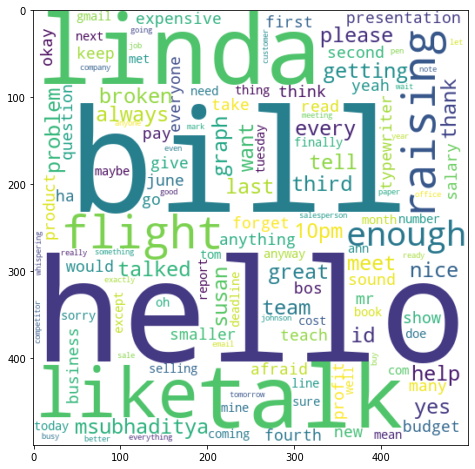

[('', 201), ('new', 7), ('product', 7), ('o.k', 7), ('mark', 5)]

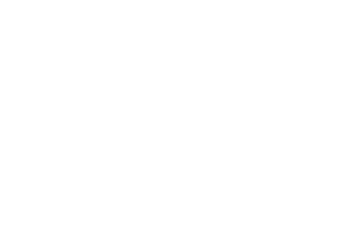

In [25]:
trends(f)

In [26]:
def new_train_gen():
    # l = ['my no is 9003401119','is your phone 9341234441','your phone no is 8341934568','here is my no 8261348649','here is my no 6713401897']
    l = [
        "my email is ~msubhaditya@gmail.com",
        "is your email id ~rules@yahoo.com",
        "your email is ~aditya@rediff.com", "here is email ~bce@mail.com",
        "here is email id ~hello@find.in"
    ]
    s = ''
    for a in l:
        s += "[({},{},'EMAIL')]\n".format(
            re.search(r'~', a).start() + 1, len(a))
    print(s)


In [27]:
def new_sp_model():
    TRAIN_DATA = [(u"my no is 9003401119", {
        "entities": [(9, 19, "PHONE")]
    }), (u"is your phone 9341234441", {
        "entities": [(14, 24, "PHONE")]
    }), (u"your phone number is 8341934568", {
        "entities": [(17, 27, "PHONE")]
    }), (u"here is my no 8261348649", {
        "entities": [(14, 24, "PHONE")]
    }), (u"here is my number 6713401897", {
        "entities": [(14, 24, "PHONE")]
    }),
        (u"my email is msubhaditya@gmail.com", {
            "entities": [(12, 34, "EMAIL")]
        }),
        (u"is your email id rules@yahoo.com", {
            "entities": [(17, 33, "EMAIL")]
        }),
        (u"your email is aditya@rediff.com", {
            "entities": [(14, 32, "EMAIL")]
        }),
        (u"here is email bce@mail.com", {
            "entities": [(14, 27, "EMAIL")]
        }),
        (u"here my email id hello@find.in", {
            "entities": [(17, 31, "EMAIL")]
        })]
    nlp = spacy.blank('en')
    # optimizer = nlp.begin_training()
    # for i in range(20):
    #     random.shuffle(TRAIN_DATA)
    #     for text, annotations in TRAIN_DATA:
    #         nlp.update([text], [annotations], sgd=optimizer)

    batches = spacy.util.minibatch(TRAIN_DATA)
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(texts, annotations)
    nlp.to_disk("newmod")

In [46]:
def return_context(docu):

    nlp = spacy.load('en_core_web_sm')
    doc = nlp(docu)
    fin_dic = {}
    for ent in doc.ents:
        fin_dic[ent.text] = ent.label_
    return json.dumps(fin_dic, sort_keys=True)

In [30]:
def context_json(p):
    dic = json.loads(return_context(p))
    d_final = {'persons': [], 'phone': [], 'emails': [], 'date': []}
    d_final['phone'].extend(re.findall(r'\d{10}', p))
    d_final['emails'].extend(re.findall(r'\S+@\S+', p))

    for a in dic:
        if dic[a] == 'PERSON':
            d_final['persons'].append(a)
        if dic[a] == 'DATE':
            d_final['date'].append(a)
    l = []
    for a in d_final:
        l.append(d_final[a])

    pd.DataFrame({k: pd.Series(l) for k, l in d_final.items()}).to_csv('output.csv',columns = ['persons','phone','emails','date'])
    # print(json.dumps(d_final))
    return json.dumps(d_final)


# Contexts

In [47]:
context_json(f)

'{"persons": ["ann", "ann nice", "linda", "mark", "mark johnson", "susan", "tom"], "phone": ["9003401119"], "emails": ["msubhaditya@gmail.com"], "date": ["10 june 2019", "every year", "last month", "next month", "next year", "this year", "today", "tomorrow", "tuesday 10pm"]}'